In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np

WORK_PATH = "./"
SOURCE_PATH = os.path.join(WORK_PATH, "src")
sys.path.append(SOURCE_PATH)
EXPORT_PATH = os.path.join(WORK_PATH, "export")

In [3]:
DATA_PATH = os.path.join("..", "data")

In [4]:
from graphnics import FenicsGraph, TubeFile

/home/pierce/Software/environments/cmor_mdanderson/lib/python3.12/site-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [ ]:
import tissue, fem, visualize

TEST_GRAPH = FenicsGraph()

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],
    1: [0.010, 0.020, 0.015],
    2: [0.022, 0.013, 0.015],
    3: [0.022, 0.028, 0.015],
    4: [0.015, 0.005, 0.015],
    5: [0.015, 0.035, 0.015],
    6: [0.038, 0.005, 0.015],
    7: [0.038, 0.035, 0.015]
}

for node_id, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node_id, pos=pos)
    
TEST_GRAPH_EDGES = [
    (0, 1, 0.004),
    (1, 2, 0.003),
    (1, 3, 0.003),
    (2, 4, 0.002),
    (2, 6, 0.003),
    (3, 5, 0.002),
    (3, 7, 0.003)
]

for (u, v, radius) in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

TEST_OMEGA_BOUNDS = [[-0.01, 0, 0], [0.05, 0.04, 0.03]]

TEST_XAXIS_PLANE = tissue.AxisPlane(0, -0.01)

TEST_MEASURE = tissue.DomainBuild(
    TEST_GRAPH,
    Omega_bounds = TEST_OMEGA_BOUNDS,
    Omega_mesh_voxel_dim = (16, 16, 16),
    Lambda_padding = 0.008,
    Lambda_num_nodes_exp = 5,
    Lambda_inlet = [0],
    Omega_sink = TEST_XAXIS_PLANE
)

CUBES_TEST = fem.SubCubes(
    domain = TEST_MEASURE,
    gamma = 0,
    gamma_R = 1.0e-6,
    gamma_a = 1.0e-6,
    mu = 1.0e-3,
    k_t = 1.0e-10,
    k_v = 1.0e-10,
    P_in = 100.0 * 133.322,
    p_cvp = 1.0 * 133.322,
    lower_cube_bounds = [[0.0,0.0,0.0],[0.01,0.01,0.01]],
    upper_cube_bounds = [[0.033, 0.03, 0.01],[0.043,0.04,0.02]]
)

CUBES_TEST.print_diagnostics()

Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 1352.95it/s]


In [ ]:
cube_lower_bounds = CUBES_TEST.lower_cube_bounds
cube_upper_bounds = CUBES_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

fig1 = visualize.plot_with_boundaries(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds,
     cube_upper=cube_upper_bounds)
fig1.show()

In [ ]:
import datetime
import pytz

cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"output_{timestamp}"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBES_TEST.save_vtk(SAVE_PATH)

In [ ]:
fig1 = visualize.plot_path_pressure(CUBES_TEST.uh1d, TEST_GRAPH, [0, 1, 3, 7])
fig1.show()

In [ ]:
visualize.plot_with_boundaries_plotly(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds,
     cube_upper=cube_upper_bounds)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import pytz

default_params = {
    'domain': measure_builder,
    'gamma': 1.0e-6,  
    'gamma_R': 1.0e-7,
    'gamma_a': 1.0e-7,
    'mu': 1.0e-3,     
    'k_t': 1.0e-10,   
    'k_v': 1.0e-11,   
    'P_in': 100 * 133.322,
    'p_cvp': 1.0 * 133.322,
    'lower_cube_bounds': [[0.0, 0.0, 0.0], [0.01, 0.01, 0.01]],
    'upper_cube_bounds': [[0.033, 0.03, 0.01], [0.043, 0.04, 0.02]]
}

def run_sweep(param_name, values, defaults):
    results = []
    for val in values:
        params = defaults.copy()
        params[param_name] = val
        
        cube_test = fem.SubCubes(**params)
        upper_total = cube_test.compute_upper_cube_flux()
        upper_in    = cube_test.compute_upper_cube_flux_in()
        upper_out   = cube_test.compute_upper_cube_flux_out()
        lower_out   = cube_test.compute_lower_cube_flux_out()
        results.append((upper_total, upper_in, upper_out, lower_out))
    return results

def perform_sweeps(num_points=50, subset_params=['k_t', 'gamma', 'gamma_R']):
    sweep_configs = {
        'k_t': {
            'values': np.logspace(-18, -8, num_points),
            'xlabel': "Tissue Permeability k_t",
            'title': "Cube Flux vs. Tissue Permeability k_t",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Gamma",
            'title': "Cube Flux vs. Gamma",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma_R': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Gamma_R",
            'title': "Cube Flux vs. Gamma_R",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        }
    }
    
    data = []
    
    for param in subset_params:
        config = sweep_configs[param]
        values = config['values']
        fluxes = run_sweep(param, values, default_params)
        
        for val, (upper_total, upper_in, upper_out, lower_out) in zip(values, fluxes):
            data.append({
                'sweep_param': param,
                'sweep_value': val,
                'upper_total': upper_total,
                'upper_in': upper_in,
                'upper_out': upper_out,
                'lower_out': lower_out,
                'xlabel': config['xlabel'],
                'title': config['title'],
                'plot_type': config['plot_type'],
                'grid_kwargs': config['grid_kwargs']
            })
    
    df = pd.DataFrame(data)
    return df, sweep_configs

cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
output_dir = os.path.join(EXPORT_PATH, f"output_sweeps_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

def plot_results(df, sweep_configs, directory, subset_params=['k_t', 'gamma', 'gamma_R']):
    for param in subset_params:
        config = sweep_configs[param]
        df_param = df[df['sweep_param'] == param]
        
        fig1, ax1 = plt.subplots(figsize=(10, 6))
        if config['plot_type'] == 'semilogx':
            ax1.semilogx(df_param['sweep_value'], df_param['upper_total'],
                         marker='o', linestyle='-', label="Upper Total Flux")
            ax1.semilogx(df_param['sweep_value'], df_param['upper_in'],
                         marker='s', linestyle='--', label="Upper Flux In")
            ax1.semilogx(df_param['sweep_value'], df_param['upper_out'],
                         marker='^', linestyle='-.', label="Upper Flux Out")
        else:
            ax1.plot(df_param['sweep_value'], df_param['upper_total'],
                     marker='o', linestyle='-', label="Upper Total Flux")
            ax1.plot(df_param['sweep_value'], df_param['upper_in'],
                     marker='s', linestyle='--', label="Upper Flux In")
            ax1.plot(df_param['sweep_value'], df_param['upper_out'],
                     marker='^', linestyle='-.', label="Upper Flux Out")
        ax1.set_xlabel(config['xlabel'])
        ax1.set_ylabel("Upper Cube Flux")
        ax1.set_title(config['title'] + " (Upper Fluxes)")
        ax1.grid(True, **config['grid_kwargs'])
        ax1.legend()
        
        fig1_filename = os.path.join(directory, f"{param}_upper_sweep.png")
        fig1.savefig(fig1_filename)
        plt.show()
        plt.close(fig1)
        
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        if config['plot_type'] == 'semilogx':
            ax2.semilogx(df_param['sweep_value'], df_param['lower_out'],
                         marker='o', linestyle='-', label="Lower Flux Out")
        else:
            ax2.plot(df_param['sweep_value'], df_param['lower_out'],
                     marker='o', linestyle='-', label="Lower Flux Out")
        ax2.set_xlabel(config['xlabel'])
        ax2.set_ylabel("Lower Cube Flux")
        ax2.set_title(config['title'] + " (Lower Flux Out)")
        ax2.grid(True, **config['grid_kwargs'])
        ax2.legend()
        
        fig2_filename = os.path.join(directory, f"{param}_lower_sweep.png")
        fig2.savefig(fig2_filename)
        plt.show()
        plt.close(fig2)

def save_data_to_csv(df, directory, filename="sweep_results.csv"):
    file_path = os.path.join(directory, filename)
    df.to_csv(file_path, index=False)
    print(f"Data saved to {file_path}")

Averaging over 112 cells: 100%|██████████| 112/112 [00:00<00:00, 768.00it/s]


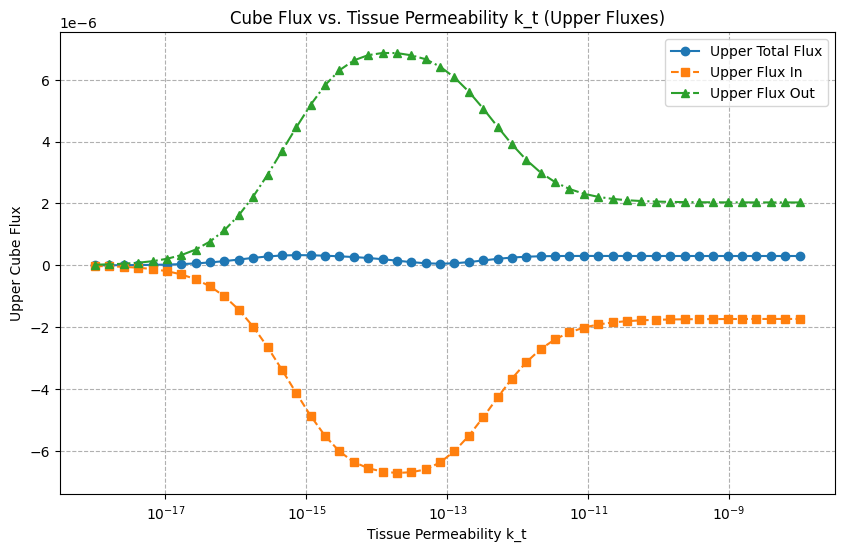

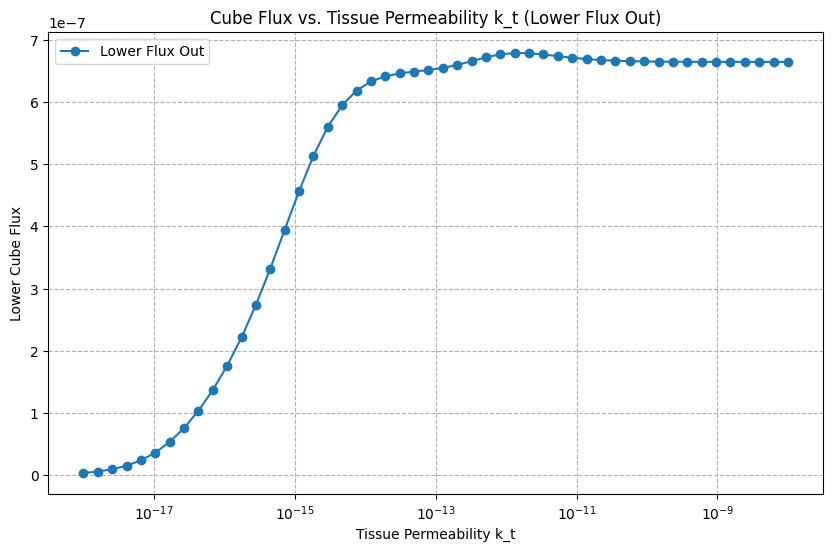

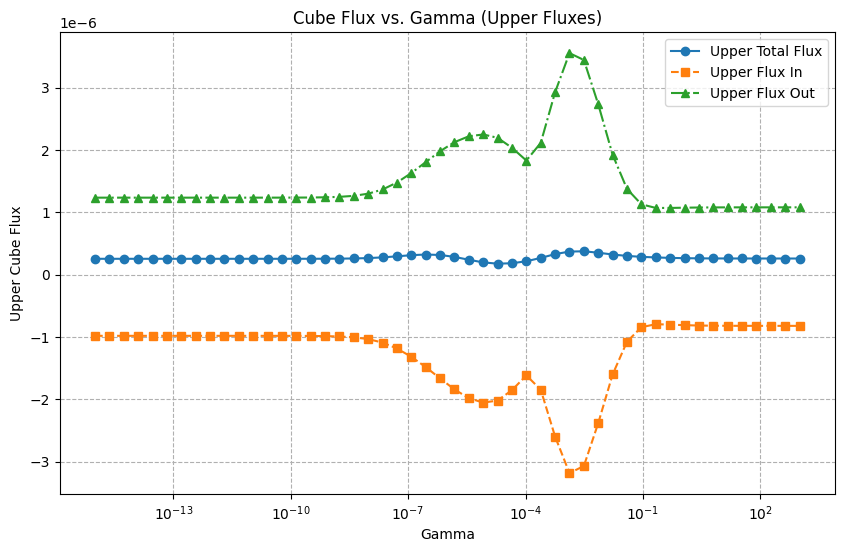

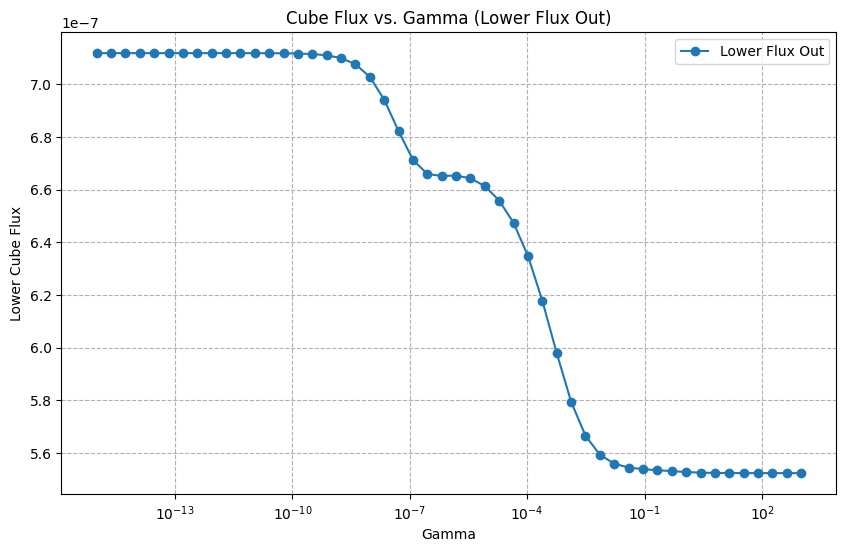

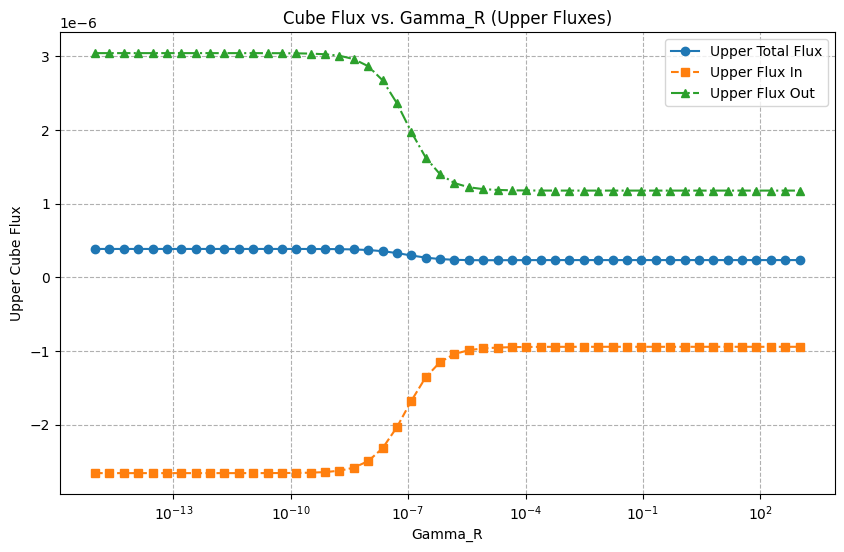

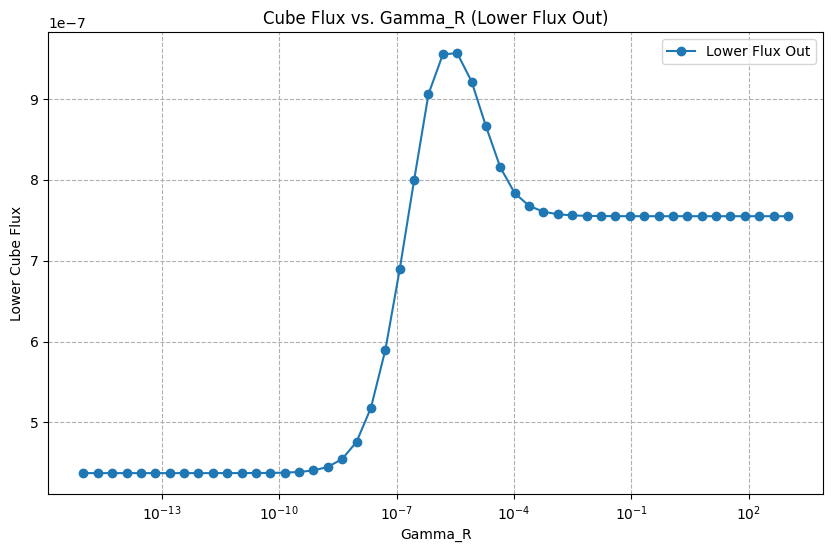

Data saved to ./export/output_sweeps_20250323_1335/sweep_results.csv


In [12]:
df_results, sweep_configs = perform_sweeps(num_points=50)
plot_results(df_results, sweep_configs, output_dir)
save_data_to_csv(df_results, output_dir)